In [31]:
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import tensorflow_hub as hub

# Configurations
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['axes.grid'] = False

# Load TensorFlow Hub model for Fast Style Transfer
def load_models():
    print("Loading pre-trained models...")
    hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    style_content_model = StyleContentModel(style_layers, content_layers)
    print("Models loaded successfully!")
    return hub_model, style_content_model

# Define style and content layers (for the style content loss approach)
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Function to extract VGG19 layers
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return tf.keras.Model([vgg.input], outputs)

# Model for extracting style and content
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = [gram_matrix(output) for output in outputs[:self.num_style_layers]]
        content_outputs = outputs[self.num_style_layers:]

        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

        return {'style': style_dict, 'content': content_dict}

# Helper Functions
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    num_locations = tf.cast(input_tensor.shape[1] * input_tensor.shape[2], tf.float32)
    return result / num_locations

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

print("Model loaded successfully!")


Loading pre-trained model...
Model loaded successfully!


model 1 TensorFlow Hub Model (Fast Style Transfer) Stylization

In [33]:
# Load images for stylization
def load_img(path_to_img, max_dim=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    scale = max_dim / max(shape)
    img = tf.image.resize(img, tf.cast(shape * scale, tf.int32))
    return img[tf.newaxis, :]

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

def load_and_display_images(content_path, style_path):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image')
    plt.show()

    return content_image, style_image

def run_style_transfer(content_image, style_image):
    stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
    display.display(tensor_to_image(stylized_image))

# Define style and content loss
def style_content_loss(outputs, style_targets, content_targets, style_weight=1e-2, content_weight=1e4):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs])
    style_loss *= style_weight / len(style_layers)
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs])
    content_loss *= content_weight / len(content_layers)
    
    return style_loss + content_loss

# Training function for style and content layers (if needed)
@tf.function
def train_step(image, style_targets, content_targets):
    with tf.GradientTape() as tape:
        outputs = style_content_model(image)
        loss = style_content_loss(outputs, style_targets, content_targets)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Use this function to load images and run the style transfer
def stylize_images(content_image_path, style_image_path):
    content_image, style_image = load_and_display_images(content_image_path, style_image_path)
    run_style_transfer(content_image, style_image)
    print("Stylization completed!")


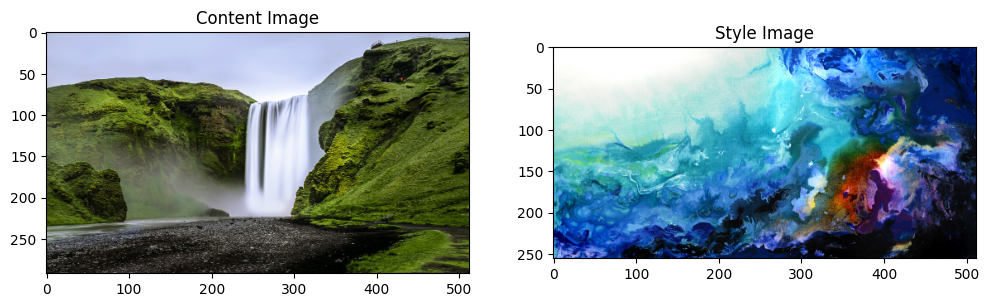

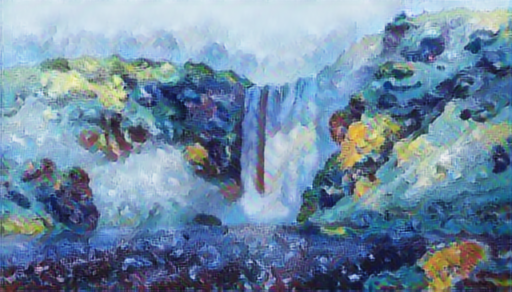

Stylization completed!


In [34]:
# Stylize new content and style images
content_image_path = 'content5.jpg'
style_image_path = 'style7.jpg'  

stylize_images(content_image_path, style_image_path)


model 2 - Custom Implementation : Training Loop with Epochs

In [15]:
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import tensorflow_hub as hub

# Configurations
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['axes.grid'] = False

# Load TensorFlow Hub model for Fast Style Transfer
def load_models():
    print("Loading pre-trained models...")
    hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
    style_content_model = StyleContentModel(style_layers, content_layers)
    print("Models loaded successfully!")
    return hub_model, style_content_model

# Define style and content layers
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Function to extract VGG19 layers
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return tf.keras.Model([vgg.input], outputs)

# Model for extracting style and content
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = [gram_matrix(output) for output in outputs[:self.num_style_layers]]
        content_outputs = outputs[self.num_style_layers:]

        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

        return {'style': style_dict, 'content': content_dict}

# Load models once
hub_model, style_content_model = load_models()


Loading pre-trained models...
Models loaded successfully!


In [16]:
# Helper Functions
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img, max_dim=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    scale = max_dim / max(shape)
    img = tf.image.resize(img, tf.cast(shape * scale, tf.int32))
    return img[tf.newaxis, :]

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)


In [19]:
# Define the style and content transfer function
def run_style_transfer(content_image_path, style_image_path, epochs=10, steps_per_epoch=100):
    content_image = load_img(content_image_path)
    style_image = load_img(style_image_path)

    # Initialize the generated image
    image = tf.Variable(content_image)

    # Define targets for style and content
    style_targets = style_content_model(style_image)['style']
    content_targets = style_content_model(content_image)['content']

    # Define style and content loss
    style_weight = 1e-2
    content_weight = 1e4

    def style_content_loss(outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs])
        style_loss *= style_weight / len(style_layers)

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs])
        content_loss *= content_weight / len(content_layers)
        
        return style_loss + content_loss

    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    @tf.function
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = style_content_model(image)
            loss = style_content_loss(outputs)
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(tf.clip_by_value(image, 0.0, 1.0))

    # Training loop
    start = time.time()
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            train_step(image)
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print(f"Epoch {epoch + 1}/{epochs} completed.")

    end = time.time()
    print(f"Total time: {end - start:.1f} seconds")
    return tensor_to_image(image)


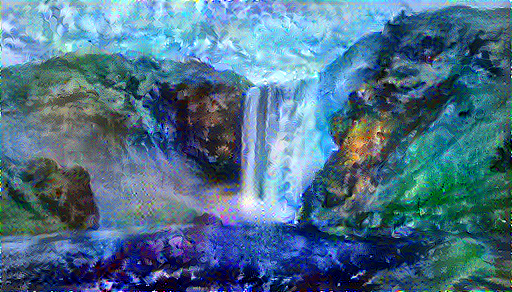

Epoch 10/10 completed.
Total time: 1352.6 seconds


In [21]:
# Stylize new content and style images
content_image_path = 'content5.jpg' 
style_image_path = 'style7.jpg' 
# Run style transfer on the new images
stylized_image = run_style_transfer(content_image_path, style_image_path)